# GPR-Augmented ANN Training Tutorial

This tutorial demonstrates how to use `aenet-gpr` for **data augmentation**, enabling the training of **ANN potentials** via the **GPR-ANN framework**.

GPR-ANN reference:
- [In Won Yeu, Alexander Urban, Nongnuch Artrith et al., “Scalable Training of Neural Network Potentials for Complex Interfaces Through Data Augmentation”, *npj Computational Materials* 11, 156 (2025)](https://doi.org/10.1038/s41524-025-01651-0)

The tutorial includes:
- Generating augmented training data using GPR
- Training an ANN potential on the reference and augmented dataset
- Comparing results between:
  - **GPR-ANN** (indirect force training via GPR-augmented data)
  - **Original-ANN** (energy-only training without force information)

In [1]:
try:
    import torch
    print("successfully imported torch")
    print(torch.__version__)
except ImportError:
    !! pip install torch torchvision torchaudio --user --index-url https://download.pytorch.org/whl/cpu
    print("completed installing torch")

successfully imported torch
2.6.0+cu124


In [2]:
try:
    import numpy as np
    print("successfully imported numpy")
    print(np.__version__)
except ImportError:
    !! pip install numpy --user --upgrade
    print("completed installing numpy")

successfully imported numpy
1.26.4


In [3]:
try:
    from matplotlib import pyplot as plt
    print("successfully imported matplotlib")
except ImportError:
    !! pip install matplotlib --user --upgrade
    print("completed installing matplotlib")

successfully imported matplotlib


In [4]:
!! pip install aenet-gpr --user --upgrade
print("completed installing aenet-gpr")

! pip show aenet-gpr

completed installing aenet-gpr
Name: aenet-gpr
Version: 2.1.6
Summary: Atomistic simulation tools based on Gaussian Processes Regression
Home-page: https://github.com/atomisticnet/aenet-gpr
Author: In Won Yeu
Author-email: iy2185@columbia.edu
License: MPL-2.0
Location: /data/home/iy2185/.local/lib/python3.12/site-packages
Requires: ase, chemcoord, dscribe
Required-by: 


In [5]:
import os, sys, site
sys.path.append(site.USER_SITE)

import aenet_gpr
print(aenet_gpr.__version__)

from aenet_gpr.util import ReferenceData, standard_output, inverse_standard_output
from aenet_gpr.src import gpr_batch
from aenet_gpr.inout import io_train_parameters, io_test_parameters

2.1.6


In [6]:
from IPython.display import Image

try:
    import ase.io
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")
    
    import ase.io
    print("successfully imported ase")

successfully imported ase


# 1. Read reference training/test data from xsf files

We are using train/test data of H-H Lennard-Jones potential prepared in `aenet-gpr/example/1_H2/`

In [50]:
import os.path

! rm -rf 1_H2
! mkdir 1_H2

if os.path.isfile("../example/1_H2/train_set.zip"):
    ! unzip -oq ../example/1_H2/train_set.zip -d ./1_H2/
    print("number of train data:")
    ! find ./1_H2/train_set/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/train_set.zip
    ! unzip -oq train_set.zip -d ./1_H2/
    ! rm train_set.zip
    print("number of train data:")
    ! find ./1_H2/train_set/ -type f | wc -l

--2025-09-26 10:44:31--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/train_set.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/train_set.zip [following]
--2025-09-26 10:44:31--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/train_set.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4676 (4.6K) [application/zip]
Saving to: ‘train_set.zip’

train_set.zip       100%[===================>]   4.57K  --.-KB/s    in 0s      

2025-09-26 10:44:31 (18.9 MB/s) - ‘train_set.zip’ 

In [51]:
if os.path.isfile("../example/1_H2/test_set.zip"):
    ! unzip -oq ../example/1_H2/test_set.zip -d ./1_H2/
    print("number of test data:")
    ! find ./1_H2/test_set/ -type f | wc -l
else:
    ! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/test_set.zip
    ! unzip -oq test_set.zip -d ./1_H2/
    ! rm test_set.zip
    print("number of test data:")
    ! find ./1_H2/test_set/ -type f | wc -l

--2025-09-26 10:44:32--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/test_set.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/test_set.zip [following]
--2025-09-26 10:44:32--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/test_set.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122489 (120K) [application/zip]
Saving to: ‘test_set.zip’

test_set.zip        100%[===================>] 119.62K  --.-KB/s    in 0.02s   

2025-09-26 10:44:33 (6.14 MB/s) - ‘test_set.zip’ sav

In [52]:
import glob


train_xsf_files = glob.glob("./1_H2/train_set/file_*")
train_xsf_files.sort()

train_data = ReferenceData(structure_files=train_xsf_files, file_format='xsf')
train_data.set_data()

print(train_data.energy.shape)
print(train_data.force.shape)

(7,)
(7, 2, 3)


In [53]:
test_xsf_files = glob.glob("./1_H2/test_set/file_*")
test_xsf_files.sort()

test_data = ReferenceData(structure_files=test_xsf_files, file_format='xsf')
test_data.set_data()

print(test_data.energy.shape)
print(test_data.force.shape)

(200,)
(200, 2, 3)


In [54]:
atoms = ase.io.read(test_xsf_files[0])
ase.io.write('H2.png', atoms)
Image("H2.png")

# 2. Model train

Second, construct a GPR model fitted to training energy and force data (7 sample points). 

In this example, default settings, energy/force standardization and sqexp kernel parameters, are used.

In [55]:
train_data.config_calculator(fit_weight=False, fit_scale=False)

io_train_parameters(data_param=train_data.write_params())


Training parameters
{'num_data': 7, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(1747.2449, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['H', 'H'], 'num_atom': 2}



# 3. Model evaluation for test set

Finally, using the constructed GPR model, evaluate energy and force of test structures (200 structures).

In [56]:
test_data.calculator = train_data.calculator

io_test_parameters(data_param=test_data.write_params())

energy_test_gpr, force_test_gpr, uncertainty_test_gpr = test_data.evaluation(get_variance=True)


Test parameters
{'num_data': 200, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64), 'prior': tensor(1747.2449, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['H', 'H'], 'num_atom': 2}



Since the training energy/force values were standardized, the raw predictions should also be standardized.

Final predictions on energy and force can be obtained from inverse standardization.

In [57]:
if train_data.standardization:
    energy_test_gpr, force_test_gpr = inverse_standard_output(energy_ref=train_data.energy,
                                                              scaled_energy_target=energy_test_gpr,
                                                              scaled_force_target=force_test_gpr)

abs_force_test_gpr = np.linalg.norm(force_test_gpr, axis=2)
abs_force_test = np.linalg.norm(test_data.force, axis=2)

print("Energy MAE (eV):", np.absolute(np.subtract(energy_test_gpr, test_data.energy)).mean())
print("Force MAE (eV/Ang):", np.absolute(np.subtract(abs_force_test_gpr, abs_force_test)).mean())

Energy MAE (eV): 0.002753264542017503
Force MAE (eV/Ang): 0.10276022081180339


# 4. Visualize the results

Now, let's compare the GPR predictions with the target Lennard-Jones potential.

The results will be shown by energy/force vs H-H bond distance plots.

In [58]:
d_train = []
for image in train_data.images:
    d_train.append(np.linalg.norm(image.get_positions()[1] - image.get_positions()[0]))

d_test = []
for image in test_data.images:
    d_test.append(np.linalg.norm(image.get_positions()[1] - image.get_positions()[0]))

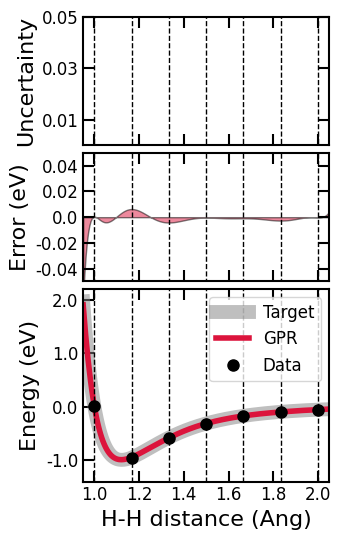

In [59]:
fig = plt.figure(figsize=(3.5, 5.5))
ax1, ax2, ax3 = fig.subplots(3, 1, height_ratios=[1, 1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'} 


# The 1st plot
ax1.fill_between(d_test, uncertainty_test_gpr, 0, label='Uncertainty', color='crimson', alpha=0.5, edgecolor='black')
ax1.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

# ax1.set_xlabel("Error in energy [eV]", fontdict=font_x)
ax1.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax1.get_xticks()]
ax1.set_xticks(x_labels)
ax1.set_xlim([0.95, 2.05])
ax1.set_xticklabels(x_labels, fontdict=font_tick)

ax1.set_ylabel('Uncertainty', fontdict=font_y)
ax1.set_ylim(0, 0.05)
y_labels = [round(label, 3) for label in ax1.get_yticks()]
y_labels = [0.01, 0.03, 0.05]
ax1.set_yticks(y_labels)
ax1.set_ylim([0, 0.05])
ax1.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax1.spines.values()]
ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax1.tick_params(direction='in', length=8, width=1.5)


# The second plot
ax2.fill_between(d_test, np.subtract(energy_test_gpr, test_data.energy), 0, color='crimson', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV)", fontdict=font_y)
ax2.set_ylim([-0.05, 0.05])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-0.04, -0.02, 0.0, 0.02, 0.04]
ax2.set_yticks(y_labels)
ax2.set_ylim([-0.05, 0.05])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.energy, '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, energy_test_gpr, '-', label='GPR', color='crimson', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.energy, 'o', label='Data', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Energy (eV)', fontdict=font_y)
ax3.set_ylim(-1.4, 2.2)
y_labels = [round(label, 2) for label in ax3.get_yticks()]
# y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-1.4, 2.2)

ax3.legend(loc='upper right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

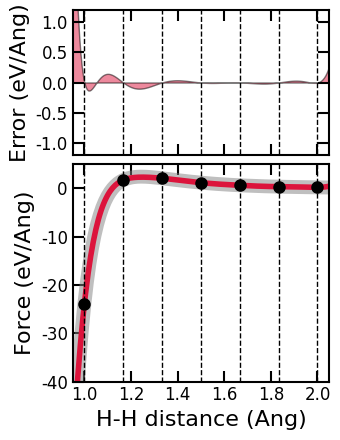

In [60]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(force_test_gpr[:, 0, 0], test_data.force[:, 0, 0]), 0, color='crimson', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV/Ang)", fontdict=font_y)
ax2.set_ylim([-1.2, 1.2])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax2.set_yticks(y_labels)
ax2.set_ylim([-1.2, 1.2])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.force[:, 0, 0], '-', color='gray', alpha=0.5, linewidth=10)
ax3.plot(d_test, force_test_gpr[:, 0, 0], '-', label='GPR', color='crimson', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.force[:, 0, 0], 'o', label='Original F', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Force (eV/Ang)', fontdict=font_y)
ax3.set_ylim(-40, 5)
y_labels = [int(label) for label in ax3.get_yticks()]
# y_labels = [-40, -30, -20, -10, 0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-40, 5)

# ax3.legend(loc='lower right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()

# 5-1. Generate additional data

In [61]:
import copy
from aenet_gpr.util import AdditionalData

In [62]:
additional_data = AdditionalData(reference_training_data=train_data)
disp = np.array([[-0.0275, 0.0, 0.0], [0.0275, 0.0, 0.0]])

for i, image in enumerate(additional_data.reference_training_data.images):
    # train position - disp
    image_disp = copy.deepcopy(image)
    pos_disp = image.get_positions() - disp
    image_disp.set_positions(pos_disp)
    additional_data.additional_images.append(image_disp)

    # train position + disp
    image_disp = copy.deepcopy(image)
    pos_disp = image.get_positions() + disp
    image_disp.set_positions(pos_disp)
    additional_data.additional_images.append(image_disp)

print("Number of train data:", len(train_data.images))
print("Number of additional data:", len(additional_data.additional_images))

Number of train data: 7
Number of additional data: 14


# 5-2. Evaluate energy of additional structures using the constructed GPR model

In [63]:
additional_data.evaluation_additional()

# 5-3. Write aenet xsf input files of train and additional data 

In [64]:
! rm -rf 1_H2/additional_xsf/
! mkdir 1_H2/additional_xsf/
additional_data.write_additional_image_xsf(path="./1_H2/additional_xsf/")

# 6-1. aenet generate (GPR-ANN, indirect force training)

In [65]:
!! git clone https://github.com/atomisticnet/aenet.git
!! cd aenet/lib && make
!! cd aenet/src && make -f makefiles/Makefile.gfortran_serial
print("completed installation of aenet")

completed installation of aenet


In [66]:
%cd ./1_H2/
%mkdir 01_aenet_generate_gpr-ann 02_aenet_train_gpr-ann 03_aenet_predict_gpr-ann
%cd ./01_aenet_generate_gpr-ann

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2
/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2/01_aenet_generate_gpr-ann


In [67]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/generate.in

--2025-09-26 10:45:34--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp [following]
--2025-09-26 10:45:35--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/01_generate/H.fingerprint.stp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235 [text/plain]
Saving to: ‘H.fingerprint.stp’

H.fingerprint.stp   100%[===================>]    

In [68]:
%ls

generate.in  H.fingerprint.stp


In [69]:
! cat H.fingerprint.stp

DESCR
  N. Artrith and A. Urban, Comput. Mater. Sci. 114 (2016) 135-150.
  N. Artrith, A. Urban, and G. Ceder, Phys. Rev. B 96 (2017) 014112.
END DESCR

ATOM H

ENV 1
H

RMIN 0.55d0

BASIS type=Chebyshev
radial_Rc = 8.0  radial_N = 10


In [70]:
! cat generate.in

OUTPUT H2.train

TYPES
1
H 0.0  | eV

SETUPS
H  H.fingerprint.stp

FILES
21
../train_set/file_0000.xsf
../train_set/file_0001.xsf
../train_set/file_0002.xsf
../train_set/file_0003.xsf
../train_set/file_0004.xsf
../train_set/file_0005.xsf
../train_set/file_0006.xsf
../additional_xsf/file_00000.xsf
../additional_xsf/file_00001.xsf
../additional_xsf/file_00002.xsf
../additional_xsf/file_00003.xsf
../additional_xsf/file_00004.xsf
../additional_xsf/file_00005.xsf
../additional_xsf/file_00006.xsf
../additional_xsf/file_00007.xsf
../additional_xsf/file_00008.xsf
../additional_xsf/file_00009.xsf
../additional_xsf/file_00010.xsf
../additional_xsf/file_00011.xsf
../additional_xsf/file_00012.xsf
../additional_xsf/file_00013.xsf


In [71]:
!! ../../aenet/bin/generate.x-2.0.4-gfortran_serial generate.in | tee generate.out

[' ======================================================================',
 '                  generate.x - training set generation                 ',
 ' ======================================================================',
 '',
 ' Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban',
 '',
 ' This program is distributed in the hope that it will be useful, but',
 ' WITHOUT ANY WARRANTY; without even the implied warranty of',
 ' MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the',
 ' Mozilla Public License, v. 2.0, for more details.',
 '',
 ' ----------------------------------------------------------------------',
 '                   Generation of training set started                  ',
 ' ----------------------------------------------------------------------',
 '',
 ' Number of atom types  : 1',
 ' types                 :    H  ',
 ' Number of structures  : 21',
 '',
 ' ----------------------------------------------------------------------',
 '                 

In [72]:
%ls

generate.in  generate.out  H2.train  H.fingerprint.stp


# 6-2. aenet train (GPR-ANN)

In [73]:
%cd ../02_aenet_train_gpr-ann/

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2/02_aenet_train_gpr-ann


In [74]:
! ln -s ../01_aenet_generate_gpr-ann/H2.train

In [75]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in

--2025-09-26 10:45:36--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in [following]
--2025-09-26 10:45:36--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/02_train/train.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241 [text/plain]
Saving to: ‘train.in’

train.in            100%[===================>]     241  --.-KB/s    in 0s      

2025-09-26 10:

In [76]:
! cat train.in

TRAININGSET H2.train
TESTPERCENT 0
ITERATIONS  500 

METHOD
bfgs

REGULARIZATION 0.001

SAVE_ENERGIES

NETWORKS
! atom   network         hidden
! types  file-name       layers  nodes:activation
  H      H.5t-5t.nn      2       5:tanh 5:tanh


In [77]:
%ls

H2.train@  train.in


In [78]:
! ../../aenet/bin/train.x-2.0.4-gfortran_serial train.in | tee train.out
!! tar cfz nn.tar.gz *.nn-* && rm -f *.nn-*

                       Training process started.                       
                                                                       
                          2025-09-26  10:45:37                         
                                                                       

 Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban

 This program is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 Mozilla Public License, v. 2.0, for more details.

 ----------------------------------------------------------------------
                       Training set normalization                      
 ----------------------------------------------------------------------

 The training set will be normalized now.  Depending on its size this
 process can take a while.  The normalized data set will be written to
 another file. Load that file in future to avo

[]

In [79]:
%ls

energies.test.0   H2.train@        H.5t-5t.nn  train.in   train.restart
energies.train.0  H2.train.scaled  nn.tar.gz   train.out  train.rngstate


# 6-3. aenet predict (GPR-ANN)

Using the trained aenet potential, predict the energy and force of test structure

In [81]:
%cd ../03_aenet_predict_gpr-ann

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2/03_aenet_predict_gpr-ann


In [82]:
! ln -s ../02_aenet_train_gpr-ann/H.5t-5t.nn

In [83]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/03_predict/predict.in

--2025-09-26 10:46:59--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_GPR-ANN/03_predict/predict.in
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/03_predict/predict.in [following]
--2025-09-26 10:46:59--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_GPR-ANN/03_predict/predict.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5255 (5.1K) [text/plain]
Saving to: ‘predict.in’

predict.in          100%[===================>]   5.13K  --.-KB/s    in 0s

In [84]:
! head -n 15 predict.in

TYPES
1
H

NETWORKS

H   H.5t-5t.nn

FORCES

FILES
200
../test_set/file_0000.xsf
../test_set/file_0001.xsf
../test_set/file_0002.xsf


In [85]:
!! ../../aenet/bin/predict.x-2.0.4-gfortran_serial predict.in | tee predict.out

[' ======================================================================',
 '                  Atomic Energy Network Interpolation                  ',
 ' ======================================================================',
 '                                                                       ',
 '                          2025-09-26  10:47:00                         ',
 '                                                                       ',
 '',
 ' Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban',
 '',
 ' This program is distributed in the hope that it will be useful, but',
 ' WITHOUT ANY WARRANTY; without even the implied warranty of',
 ' MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the',
 ' Mozilla Public License, v. 2.0, for more details.',
 '',
 ' Atomic species : H',
 ' File name      : H.5t-5t.nn',
 '',
 ' ----------------------------------------------------------------------',
 '                           Training set info.                   

In [86]:
%ls

H.5t-5t.nn@  predict.in  predict.out


In [87]:
! grep "Total energy" ./predict.out > ./energy.dat
! grep -A 2 " --------------------------------------------------------------------------------------" ./predict.out | grep -v " --------------------------------------------------------------------------------------" > ./forces.dat

In [88]:
! head -n 15 energy.dat

 Total energy               :            1.93846588 eV
 Total energy               :            1.66543403 eV
 Total energy               :            1.40231647 eV
 Total energy               :            1.15252300 eV
 Total energy               :            0.91849189 eV
 Total energy               :            0.70172564 eV
 Total energy               :            0.50290289 eV
 Total energy               :            0.32203041 eV
 Total energy               :            0.15860568 eV
 Total energy               :            0.01176999 eV
 Total energy               :           -0.11955968 eV
 Total energy               :           -0.23658459 eV
 Total energy               :           -0.34054400 eV
 Total energy               :           -0.43265818 eV
 Total energy               :           -0.51409050 eV


In [89]:
with open("energy.dat", 'r') as infile:
    lines = infile.readlines()

energy_test_aenet = []
for line in lines:
    energy_test_aenet.append(line.split()[3])
energy_test_aenet = np.asarray(energy_test_aenet, dtype=np.float64)

In [90]:
! head -n 15 forces.dat

 H      -0.475000      0.000000      0.000000    -50.043125      0.000000      0.000000
 H       0.475000      0.000000      0.000000     50.043125      0.000000      0.000000
--
 H      -0.477764      0.000000      0.000000    -48.614312      0.000000      0.000000
 H       0.477764      0.000000      0.000000     48.614312      0.000000      0.000000
--
 H      -0.480528     -0.000000     -0.000000    -46.483376      0.000000      0.000000
 H       0.480528     -0.000000     -0.000000     46.483376      0.000000      0.000000
--
 H      -0.483291      0.000000      0.000000    -43.823048      0.000000      0.000000
 H       0.483291      0.000000      0.000000     43.823048      0.000000      0.000000
--
 H      -0.486055      0.000000      0.000000    -40.808714      0.000000      0.000000
 H       0.486055      0.000000      0.000000     40.808714      0.000000      0.000000
--


In [91]:
with open("forces.dat", 'r') as infile:
    lines = infile.readlines()

force_test_aenet = np.empty((200, 2, 3))
k = 0
for j, line in enumerate(lines):
    if j % 3 != 2:
        force_test_aenet[k, j % 3, :] = np.asarray(line.split()[4:], dtype=np.float64)
    else:
        k = k + 1

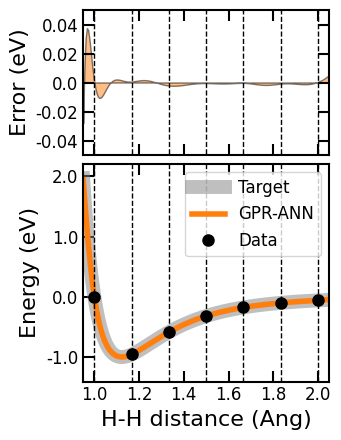

In [92]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(energy_test_aenet, test_data.energy), 0, color='tab:orange', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV)", fontdict=font_y)
ax2.set_ylim([-0.05, 0.05])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-0.04, -0.02, 0.0, 0.02, 0.04]
ax2.set_yticks(y_labels)
ax2.set_ylim([-0.05, 0.05])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.energy, '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, energy_test_aenet, '-', label='GPR-ANN', color='tab:orange', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.energy, 'o', label='Data', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Energy (eV)', fontdict=font_y)
ax3.set_ylim(-1.4, 2.2)
y_labels = [round(label, 2) for label in ax3.get_yticks()]
# y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-1.4, 2.2)

ax3.legend(loc='upper right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

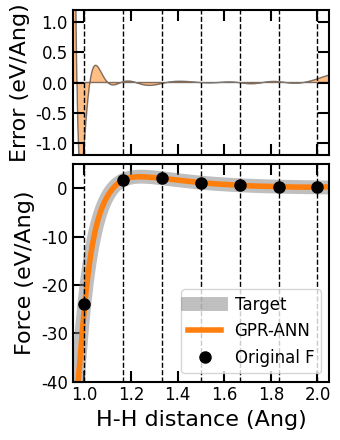

In [93]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(force_test_aenet[:, 0, 0], test_data.force[:, 0, 0]), 0, color='tab:orange', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV/Ang)", fontdict=font_y)
ax2.set_ylim([-1.2, 1.2])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax2.set_yticks(y_labels)
ax2.set_ylim([-1.2, 1.2])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.force[:, 0, 0], '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, force_test_aenet[:, 0, 0], '-', label='GPR-ANN', color='tab:orange', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.force[:, 0, 0], 'o', label='Original F', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Force (eV/Ang)', fontdict=font_y)
ax3.set_ylim(-40, 5)
y_labels = [int(label) for label in ax3.get_yticks()]
# y_labels = [-40, -30, -20, -10, 0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-40, 5)

ax3.legend(loc='lower right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()

# 7-1. aenet generate (Original-ANN, energy only training)

In [94]:
%cd ../
%mkdir 01_aenet_generate_original-ann 02_aenet_train_original-ann 03_aenet_predict_original-ann
%cd ./01_aenet_generate_original-ann

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2
/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2/01_aenet_generate_original-ann


In [95]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/01_generate/H.fingerprint.stp
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/01_generate/generate.in

--2025-09-26 10:47:10--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/01_generate/H.fingerprint.stp
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_ANN/01_generate/H.fingerprint.stp [following]
--2025-09-26 10:47:10--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_ANN/01_generate/H.fingerprint.stp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235 [text/plain]
Saving to: ‘H.fingerprint.stp’

H.fingerprint.stp   100%[===================>]     235  --.-KB

In [96]:
%ls

generate.in  H.fingerprint.stp


In [97]:
! cat H.fingerprint.stp

DESCR
  N. Artrith and A. Urban, Comput. Mater. Sci. 114 (2016) 135-150.
  N. Artrith, A. Urban, and G. Ceder, Phys. Rev. B 96 (2017) 014112.
END DESCR

ATOM H

ENV 1
H

RMIN 0.55d0

BASIS type=Chebyshev
radial_Rc = 8.0  radial_N = 10


In [98]:
! cat generate.in

OUTPUT H2.train

TYPES
1
H 0.0  | eV

SETUPS
H  H.fingerprint.stp

FILES
7
../train_set/file_0000.xsf
../train_set/file_0001.xsf
../train_set/file_0002.xsf
../train_set/file_0003.xsf
../train_set/file_0004.xsf
../train_set/file_0005.xsf
../train_set/file_0006.xsf


In [99]:
!! ../../aenet/bin/generate.x-2.0.4-gfortran_serial generate.in | tee generate.out

[' ======================================================================',
 '                  generate.x - training set generation                 ',
 ' ======================================================================',
 '',
 ' Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban',
 '',
 ' This program is distributed in the hope that it will be useful, but',
 ' WITHOUT ANY WARRANTY; without even the implied warranty of',
 ' MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the',
 ' Mozilla Public License, v. 2.0, for more details.',
 '',
 ' ----------------------------------------------------------------------',
 '                   Generation of training set started                  ',
 ' ----------------------------------------------------------------------',
 '',
 ' Number of atom types  : 1',
 ' types                 :    H  ',
 ' Number of structures  : 7',
 '',
 ' ----------------------------------------------------------------------',
 '                  

In [100]:
%ls

generate.in  generate.out  H2.train  H.fingerprint.stp


# 7-2. aenet train (Original-ANN)

In [101]:
%cd ../02_aenet_train_original-ann/

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2/02_aenet_train_original-ann


In [102]:
! ln -s ../01_aenet_generate_original-ann/H2.train

In [103]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/02_train/train.in

--2025-09-26 10:47:15--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/02_train/train.in
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_ANN/02_train/train.in [following]
--2025-09-26 10:47:15--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_ANN/02_train/train.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [text/plain]
Saving to: ‘train.in’

train.in            100%[===================>]     220  --.-KB/s    in 0s      

2025-09-26 10:47:15 (3.90 

In [104]:
! cat train.in

TRAININGSET H2.train
TESTPERCENT 0
ITERATIONS  1000 

METHOD
bfgs

SAVE_ENERGIES

NETWORKS
! atom   network         hidden
! types  file-name       layers  nodes:activation
  H      H.5t-5t.nn      2       5:tanh 5:tanh


In [105]:
%ls

H2.train@  train.in


In [106]:
! ../../aenet/bin/train.x-2.0.4-gfortran_serial train.in | tee train.out
!! tar cfz nn.tar.gz *.nn-* && rm -f *.nn-*

                       Training process started.                       
                                                                       
                          2025-09-26  10:47:16                         
                                                                       

 Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban

 This program is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 Mozilla Public License, v. 2.0, for more details.

          This means at least one fingerprint function for H is always equal to zero!
          Maybe an atomic species is not present in the reference set?
          type       = Chebyshev 0
          covariance =    0.0000000000000000     
          average    =    0.0000000000000000     
          min, max   =    0.0000000000000000        0.0000000000000000     
          This means at least one fi

[]

In [107]:
%ls

energies.test.0   H2.train@        H.5t-5t.nn  train.in   train.restart
energies.train.0  H2.train.scaled  nn.tar.gz   train.out  train.rngstate


# 7-3. aenet predict (Original-ANN)

Using the trained aenet potential, predict the energy and force of test structure

In [108]:
%cd ../03_aenet_predict_original-ann

/data/home/iy2185/2023-10-24-GPyTorch/aenet_tutorial/1_H2/03_aenet_predict_gpr-ann/1_H2/03_aenet_predict_original-ann


In [109]:
! ln -s ../02_aenet_train_original-ann/H.5t-5t.nn

In [110]:
! wget https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/03_predict/predict.in

--2025-09-26 10:51:14--  https://github.com/atomisticnet/aenet-gpr/raw/refs/heads/main/example/1_H2/aenet_ANN/03_predict/predict.in
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_ANN/03_predict/predict.in [following]
--2025-09-26 10:51:14--  https://raw.githubusercontent.com/atomisticnet/aenet-gpr/refs/heads/main/example/1_H2/aenet_ANN/03_predict/predict.in
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5255 (5.1K) [text/plain]
Saving to: ‘predict.in’

predict.in          100%[===================>]   5.13K  --.-KB/s    in 0s      

2025

In [111]:
! head -n 15 predict.in

TYPES
1
H

NETWORKS

H   H.5t-5t.nn

FORCES

FILES
200
../test_set/file_0000.xsf
../test_set/file_0001.xsf
../test_set/file_0002.xsf


In [112]:
!! ../../aenet/bin/predict.x-2.0.4-gfortran_serial predict.in | tee predict.out

[' ======================================================================',
 '                  Atomic Energy Network Interpolation                  ',
 ' ======================================================================',
 '                                                                       ',
 '                          2025-09-26  10:51:15                         ',
 '                                                                       ',
 '',
 ' Copyright (C) 2015-2018 Nongnuch Artrith and Alexander Urban',
 '',
 ' This program is distributed in the hope that it will be useful, but',
 ' WITHOUT ANY WARRANTY; without even the implied warranty of',
 ' MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the',
 ' Mozilla Public License, v. 2.0, for more details.',
 '',
 ' Atomic species : H',
 ' File name      : H.5t-5t.nn',
 '',
 ' ----------------------------------------------------------------------',
 '                           Training set info.                   

In [113]:
%ls

H.5t-5t.nn@  predict.in  predict.out


In [114]:
! grep "Total energy" ./predict.out > ./energy.dat
! grep -A 2 " --------------------------------------------------------------------------------------" ./predict.out | grep -v " --------------------------------------------------------------------------------------" > ./forces.dat

In [115]:
! head -n 15 energy.dat

 Total energy               :            0.01417213 eV
 Total energy               :            0.01402974 eV
 Total energy               :            0.01377008 eV
 Total energy               :            0.01336661 eV
 Total energy               :            0.01278719 eV
 Total energy               :            0.01199314 eV
 Total energy               :            0.01093795 eV
 Total energy               :            0.00956590 eV
 Total energy               :            0.00781051 eV
 Total energy               :            0.00559262 eV
 Total energy               :            0.00281830 eV
 Total energy               :           -0.00062354 eV
 Total energy               :           -0.00486389 eV
 Total energy               :           -0.01005666 eV
 Total energy               :           -0.01638200 eV


In [116]:
with open("energy.dat", 'r') as infile:
    lines = infile.readlines()

energy_test_aenet = []
for line in lines:
    energy_test_aenet.append(line.split()[3])
energy_test_aenet = np.asarray(energy_test_aenet, dtype=np.float64)

In [117]:
! head -n 15 forces.dat

 H      -0.475000      0.000000      0.000000     -0.016537      0.000000      0.000000
 H       0.475000      0.000000      0.000000      0.016537      0.000000      0.000000
--
 H      -0.477764      0.000000      0.000000     -0.035641      0.000000      0.000000
 H       0.477764      0.000000      0.000000      0.035641      0.000000      0.000000
--
 H      -0.480528     -0.000000     -0.000000     -0.059104      0.000000      0.000000
 H       0.480528     -0.000000     -0.000000      0.059104      0.000000      0.000000
--
 H      -0.483291      0.000000      0.000000     -0.087846      0.000000      0.000000
 H       0.483291      0.000000      0.000000      0.087846      0.000000      0.000000
--
 H      -0.486055      0.000000      0.000000     -0.122959      0.000000      0.000000
 H       0.486055      0.000000      0.000000      0.122959      0.000000      0.000000
--


In [118]:
with open("forces.dat", 'r') as infile:
    lines = infile.readlines()

force_test_aenet = np.empty((200, 2, 3))
k = 0
for j, line in enumerate(lines):
    if j % 3 != 2:
        force_test_aenet[k, j % 3, :] = np.asarray(line.split()[4:], dtype=np.float64)
    else:
        k = k + 1

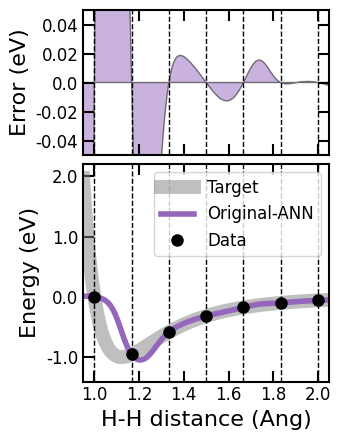

In [119]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(energy_test_aenet, test_data.energy), 0, color='tab:purple', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV)", fontdict=font_y)
ax2.set_ylim([-0.05, 0.05])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-0.04, -0.02, 0.0, 0.02, 0.04]
ax2.set_yticks(y_labels)
ax2.set_ylim([-0.05, 0.05])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)

# The third plot
ax3.plot(d_test, test_data.energy, '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, energy_test_aenet, '-', label='Original-ANN', color='tab:purple', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.energy, 'o', label='Data', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Energy (eV)', fontdict=font_y)
ax3.set_ylim(-1.4, 2.2)
y_labels = [round(label, 2) for label in ax3.get_yticks()]
# y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-1.4, 2.2)

ax3.legend(loc='upper right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

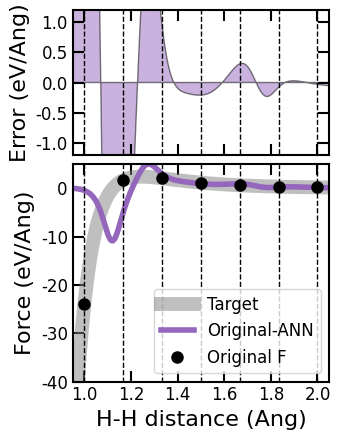

In [120]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(force_test_aenet[:, 0, 0], test_data.force[:, 0, 0]), 0, color='tab:purple', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV/Ang)", fontdict=font_y)
ax2.set_ylim([-1.2, 1.2])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax2.set_yticks(y_labels)
ax2.set_ylim([-1.2, 1.2])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)

# The third plot
ax3.plot(d_test, test_data.force[:, 0, 0], '-', color='gray', label='Target', alpha=0.5, linewidth=10)
ax3.plot(d_test, force_test_aenet[:, 0, 0], '-', label='Original-ANN', color='tab:purple', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.force[:, 0, 0], 'o', label='Original F', color='black', markersize=8)

ax3.set_xlabel('H-H distance (Ang)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Force (eV/Ang)', fontdict=font_y)
ax3.set_ylim(-40, 5)
y_labels = [int(label) for label in ax3.get_yticks()]
# y_labels = [-40, -30, -20, -10, 0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-40, 5)

ax3.legend(loc='lower right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()